In [10]:
from pyspark.sql import Column, DataFrame, SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import ArrayType, DoubleType, IntegerType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans, BisectingKMeansModel, BisectingKMeansSummary
from pyspark.ml.evaluation import ClusteringEvaluator

from typing import List

import matplotlib.pyplot as plt

import numpy as np

In [11]:
DATA_PATH = '/media/maya/Samsung_T5/quasar'

In [12]:
spark: SparkSession = SparkSession.builder.appName('Spectra_Clustering') \
                      .master('local').getOrCreate()

In [13]:
df: DataFrame = spark.read.parquet(f'{DATA_PATH}/cleaned-spectra.parquet')

In [6]:
df.dtypes

[('id', 'string'),
 ('spectra_set_id', 'string'),
 ('continuum', 'array<double>'),
 ('type', 'string'),
 ('subtype', 'string'),
 ('spectrum', 'array<double>'),
 ('z', 'double')]

In [5]:
df.count()

512657

In [17]:
continuum_df = df.select('id', explode(col('continuum')))

In [18]:
spectrum_df = df.select('id', explode(col('spectrum')))

## Explode columns

In [21]:
continuum_df.select('col').describe().show(truncate=False)

+-------+-------------------+
|summary|col                |
+-------+-------------------+
|count  |2095030990         |
|mean   |156.15468115821244 |
|stddev |588154.097899196   |
|min    |0.0                |
|max    |4.628853397548165E9|
+-------+-------------------+



In [22]:
spectrum_df.select('col').describe().show(truncate=False)

+-------+----------------------+
|summary|col                   |
+-------+----------------------+
|count  |2072059782            |
|mean   |-145.50451629888943   |
|stddev |548670.7131087978     |
|min    |-4.628853397548165E9  |
|max    |4.6147878089786634E-10|
+-------+----------------------+



### Rescale

In [7]:
@udf(DoubleType())
def max_in_array(x: ArrayType(DoubleType())) -> DoubleType():
    arr: List[DoubleType()] = [i for i in x if i != None]
    return float(np.max(arr)) if arr else -float("inf")

@udf(DoubleType())
def min_in_array(x: ArrayType(DoubleType())) -> DoubleType():
    arr: List[DoubleType()] = [i for i in x if i != None]
    return float(np.min(arr)) if arr else float("inf")

spectra_min_max = df \
    .select(min_in_array(col('spectrum')), min_in_array(col('continuum')),
            max_in_array(col('continuum')), max_in_array(col('spectrum'))).cache()

In [8]:
spectra_min_max.describe().show(truncate=False)

+-------+----------------------+-----------------------+-----------------------+----------------------+
|summary|min_in_array(spectrum)|min_in_array(continuum)|max_in_array(continuum)|max_in_array(spectrum)|
+-------+----------------------+-----------------------+-----------------------+----------------------+
|count  |512657                |512657                 |512657                 |512657                |
|mean   |Infinity              |Infinity               |-Infinity              |-Infinity             |
|stddev |NaN                   |NaN                    |NaN                    |NaN                   |
|min    |-4.628853397548165E9  |0.0                    |-Infinity              |-Infinity             |
|max    |Infinity              |Infinity               |4.628853397548165E9    |4.6147878089786634E-10|
+-------+----------------------+-----------------------+-----------------------+----------------------+



In [8]:
min_spectra_values = spectra_min_max.select('min_spectrum').collect()
max_spectra_values = spectra_min_max.select('max_spectrum').collect()

In [11]:
min_spectra_values = np.array(min_spectra_values)

In [20]:
np.percentile(min_spectra_values, 0.1)

-1.7350152909690405e-15

In [21]:
np.percentile(min_spectra_values, 99.9)

-4.322355765985711e-18

In [16]:
max_spectra_values = np.array(max_spectra_values)

In [22]:
np.percentile(max_spectra_values, 99.9)

1.3739437086449883e-15

In [23]:
np.percentile(max_spectra_values, 0.1)

4.482036389111347e-18

In [24]:
np.percentile(min_spectra_values, 50)

-2.5850769465020807e-17

In [25]:
np.percentile(max_spectra_values, 50)

4.8697077301730175e-17

### Rescale spectrum and continuum values

In [7]:
RESCALE: float = 1.0E17

In [8]:
@udf(ArrayType(DoubleType()))
def rescale(spectrum: ArrayType(DoubleType())) -> ArrayType(DoubleType()):
    return [x*RESCALE if x else 0.0 for x in spectrum]

In [9]:
spectra_rescaled: DataFrame = df\
    .withColumn('spectrum', rescale(col('spectrum')))\
    .withColumn('continuum', rescale(col('continuum')))

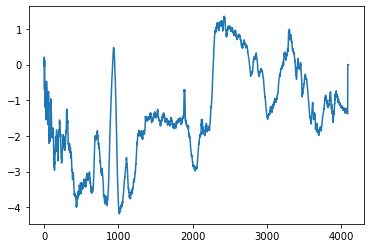

In [10]:
plt.plot(spectra_rescaled.head(1)[0].spectrum)

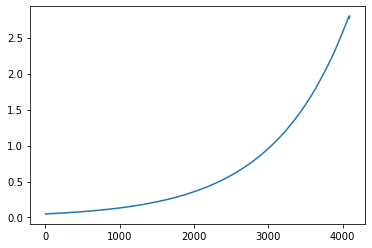

In [11]:
plt.plot(spectra_rescaled.head(1)[0].continuum)

In [12]:
spectra_rescaled.write.parquet(f'{DATA_PATH}/spectra_rescaled.parquet')

### Spectrum vector feature

In [5]:
spectra_rescaled: DataFrame = spark.read.parquet(f'{DATA_PATH}/spectra_rescaled.parquet').cache()

Explode an array column into many columns.

In [9]:
SPECTRUM_SIZE: int = 4096
SPECTRUM_COLUMNS: List[Column] = list(map(lambda i: spectra_rescaled.spectrum[i], list(range(0, SPECTRUM_SIZE))))
SPECTRUM_COLUMN_NAMES: List[str] = list(map(lambda i: f'spectrum[{i}]', list(range(0, SPECTRUM_SIZE))))

In [10]:
spectra: DataFrame = spectra_rescaled.select(SPECTRUM_COLUMNS)

Construct a vector using VectorAssembler.

In [11]:
vecAssembler: VectorAssembler = VectorAssembler(outputCol='features')
vecAssembler.setInputCols(SPECTRUM_COLUMN_NAMES)

VectorAssembler_82bb05ab1016

In [12]:
vectorized_spectra = vecAssembler.transform(spectra).select('features')

In [13]:
vectorized_spectra.write.parquet(f'{DATA_PATH}/vectorized_spectra.parquet')

## Simple clustering

### Bisecting KMeans

In [38]:
bkm = BisectingKMeans(k=2)
bkm.setMaxIter(10)

BisectingKMeans_783c1c00eaea

In [39]:
vectorized_spectra.dtypes

[('features', 'vector')]

In [40]:
bkm_model = bkm.fit(vectorized_spectra)

In [42]:
predictions = bkm_model.transform(vectorized_spectra)

In [44]:
evalutator = ClusteringEvaluator()

In [45]:
silhouette = evalutator.evaluate(predictions)

In [ ]:
bkm_model.save(f'{DATA_PATH}/bkm_model_1.0.0')

-----------------------------------------------------

In [7]:
bkm_model = BisectingKMeansModel.load(f'{DATA_PATH}/bkm_model_1.0.0')